[*********************100%***********************]  1 of 1 completed


(                Open      High       Low  Today Adj Close       WMA       RSI  \
 Date                                                                            
 2019-06-21 -0.107205 -0.142863 -0.102067        -0.041282 -0.024654  0.153814   
 2018-07-17  0.183070  0.173804  0.236732         0.028842  0.082562 -1.529690   
 2017-12-29  0.854094  0.810864  0.880070         0.439341  0.480904 -0.014841   
 2021-03-08  0.782468  0.911452  0.807742         1.188943  1.046012  1.134731   
 2021-01-29  0.103904  0.151451  0.103496         0.355102  0.528778  0.613442   
 ...              ...       ...       ...              ...       ...       ...   
 2021-02-22  0.454495  0.561256  0.503203         0.815288  0.778929  1.153832   
 2021-05-05  0.446956  0.449491  0.465136         0.779888  0.837211 -0.538786   
 2021-06-24  1.969954  1.906160  1.892660         2.215511  2.162288  0.786164   
 2020-05-29 -1.720678 -1.726199 -1.754188        -1.540706 -1.551830  0.614651   
 2021-06-18  1.5

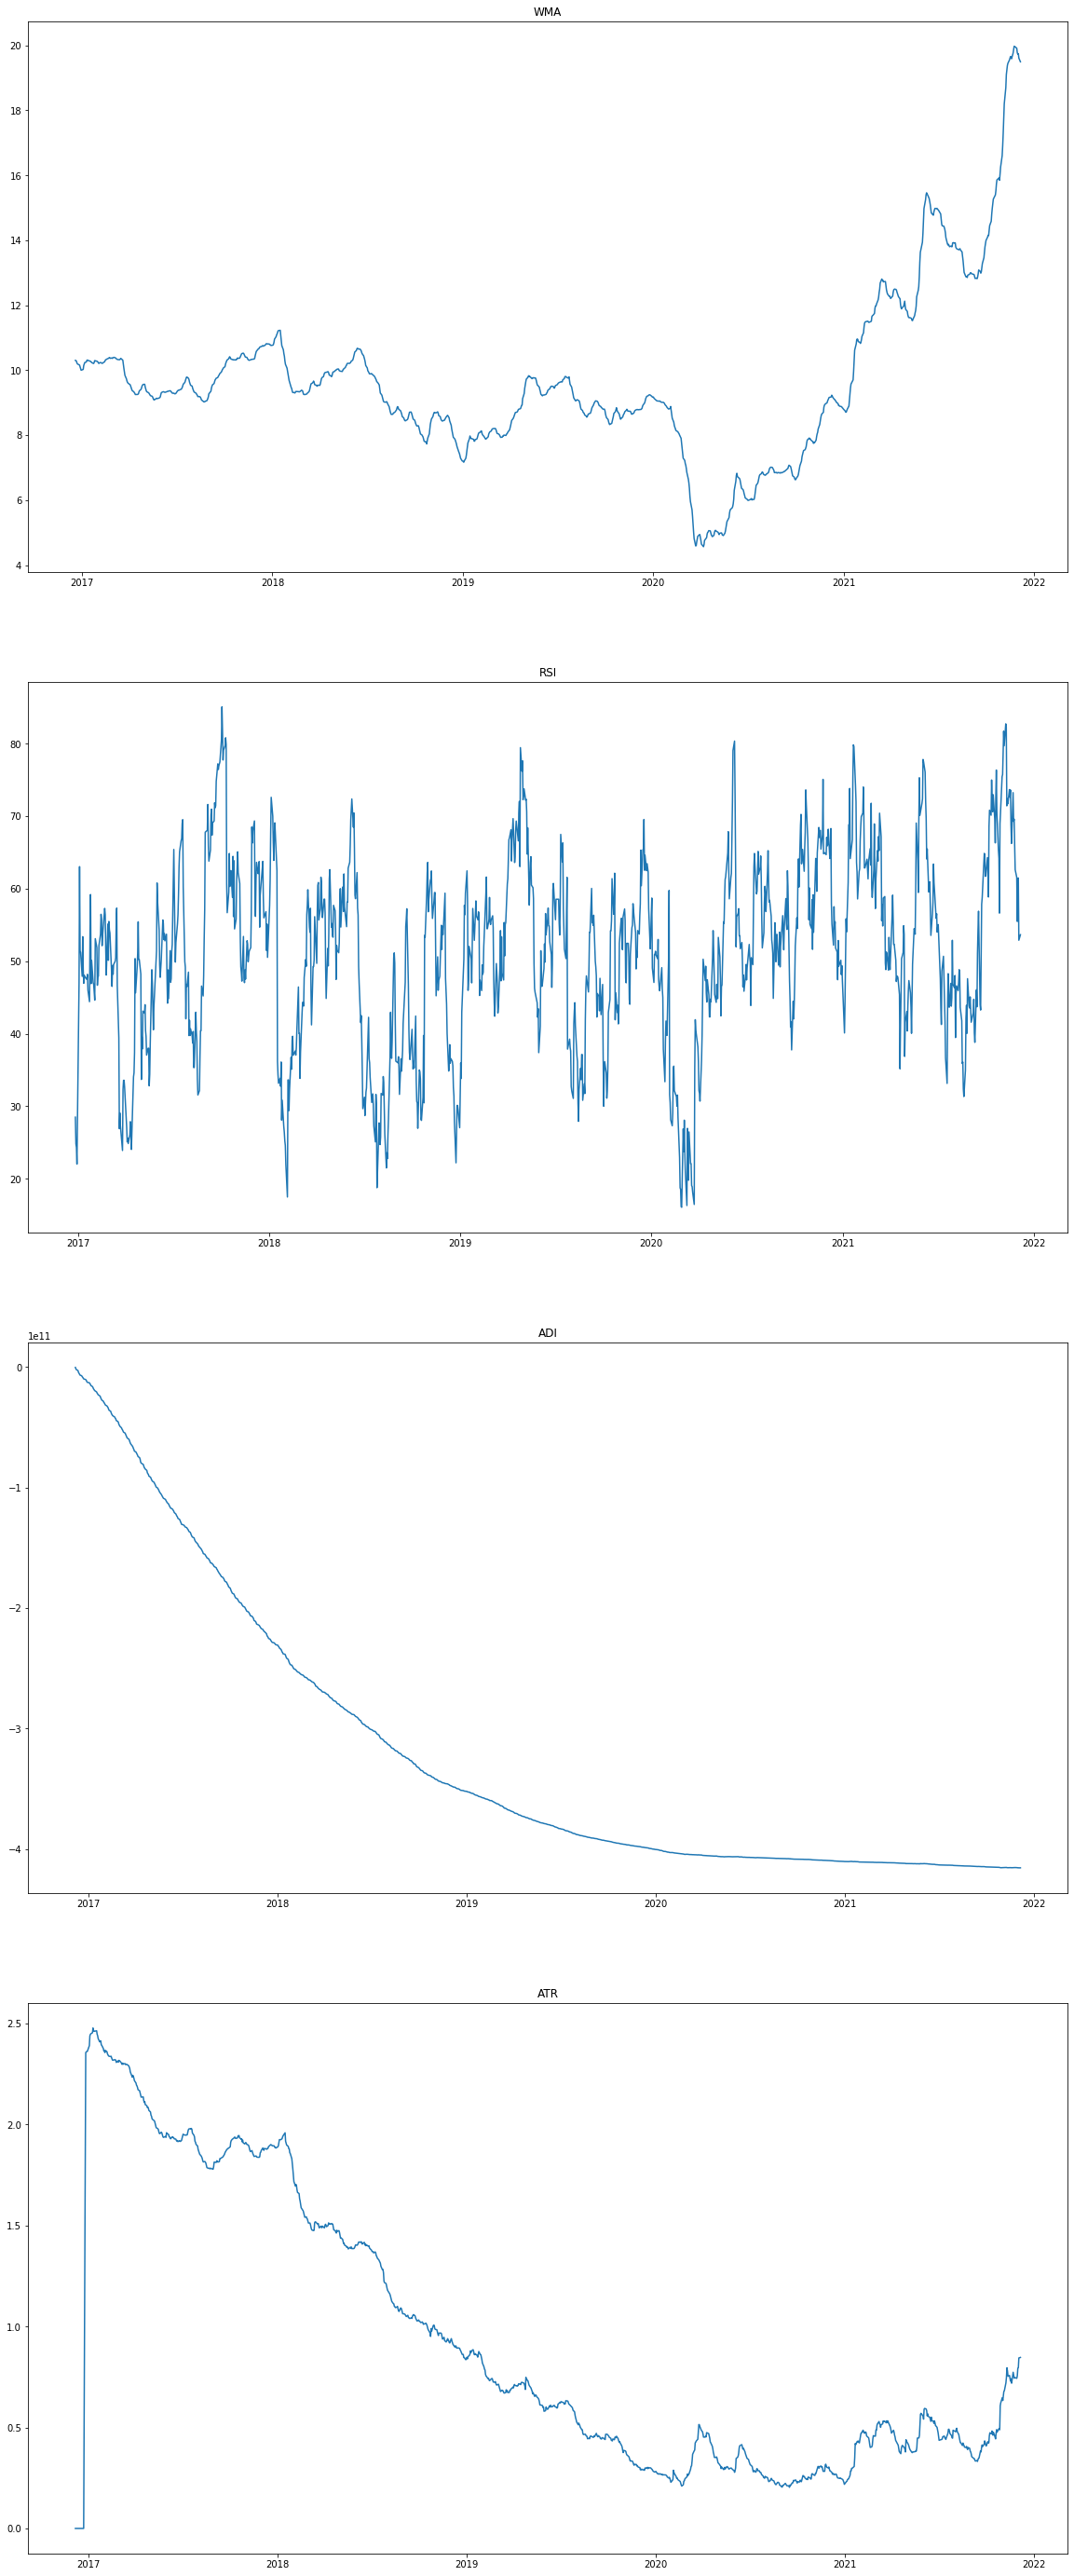

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from ta.trend import WMAIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import AccDistIndexIndicator

def ticker_data_processing(ticker, time_period):
    tick = yf.download(ticker, period=time_period)
    tickerData = tick
    
    #adjusting the Adj Close columns 
    tickerData = tickerData.drop(['Close'], axis =1)
    adjclose = tickerData['Adj Close']
    tickerData['Today Adj Close'] = adjclose
    tickerData['Adj Close'] = tickerData['Adj Close'].shift(-1)
    tickerData = tickerData.dropna()
    tickerData = tickerData.rename(columns={"Adj Close" : "Tomorrow Adj Close"})
    
    #using TA library to calculate and add TA data to the data set
    indicator_wma = WMAIndicator(close=tickerData["Today Adj Close"], window = 9)
    tickerData['WMA'] = indicator_wma.wma()
    
    indicator_rsi = RSIIndicator(close=tickerData["Today Adj Close"], window = 14)
    tickerData['RSI'] = indicator_rsi.rsi()
    
    indicator_adi = AccDistIndexIndicator(high=tickerData["High"], low=tickerData["Low"], close=tickerData["Today Adj Close"], volume=tickerData["Volume"])
    tickerData['ADI'] = indicator_adi.acc_dist_index()
    
    indicator_atr = AverageTrueRange(high=tickerData["High"], low=tickerData["Low"], close=tickerData["Today Adj Close"], window = 14)
    tickerData['ATR'] = indicator_atr.average_true_range()
    
    #graphing the TA indicators
    fig, grph = plt.subplots(4, figsize =(20, 50))
   
    grph[0].plot(tickerData['WMA'])
    grph[0].title.set_text("WMA")
    
    grph[1].plot(tickerData['RSI'])
    grph[1].title.set_text("RSI")
    
    grph[2].plot(tickerData['ADI'])
    grph[2].title.set_text("ADI")
    
    grph[3].plot(tickerData['ATR'])
    grph[3].title.set_text("ATR")
    
    #drops N/A
    tickerData = tickerData.dropna()
    
    #splitting the test and train data and dropping volume from both
    train_set, test_set = train_test_split(tickerData, test_size=0.2, random_state=42)
    train_set = train_set.drop(['Volume'], axis=1)
    test_set = test_set.drop(['Volume'], axis=1)
    
    
    #setting up the scaler, can be swapped between MinMaxScaler and StandardScaler
    scale = ['Open', 'High', 'Low', 'Today Adj Close', 'WMA', 'RSI', 'ADI', 'ATR']
    scaler = StandardScaler()

    train_set_features = train_set.drop(["Tomorrow Adj Close"], axis=1)
    train_set_labels = train_set['Tomorrow Adj Close'].copy()
    
    feature_transform = scaler.fit_transform(train_set_features[scale])
    train_prepared = pd.DataFrame(columns=scale, data=feature_transform, index=train_set_features.index)
    
    test_set_features = train_set.drop(['Tomorrow Adj Close'], axis=1)
    test_set_labels = train_set['Tomorrow Adj Close'].copy()
    
    #scaling the data
    #train_prepared = scaler.fit_transform(train_set)
    test_prepared = scaler.transform(test_set_features[scale])
    
    
    return train_prepared, train_set_labels, test_prepared, test_set_labels 

ticker_data_processing('F', '5y')

[*********************100%***********************]  1 of 1 completed
Scores: [23.08359681 20.35330465 26.93039328 31.4303775  30.88505421]
Mean: 26.536545290428773
Standared deviation: 4.316701466555148
MAPE:  0.0378161971189525


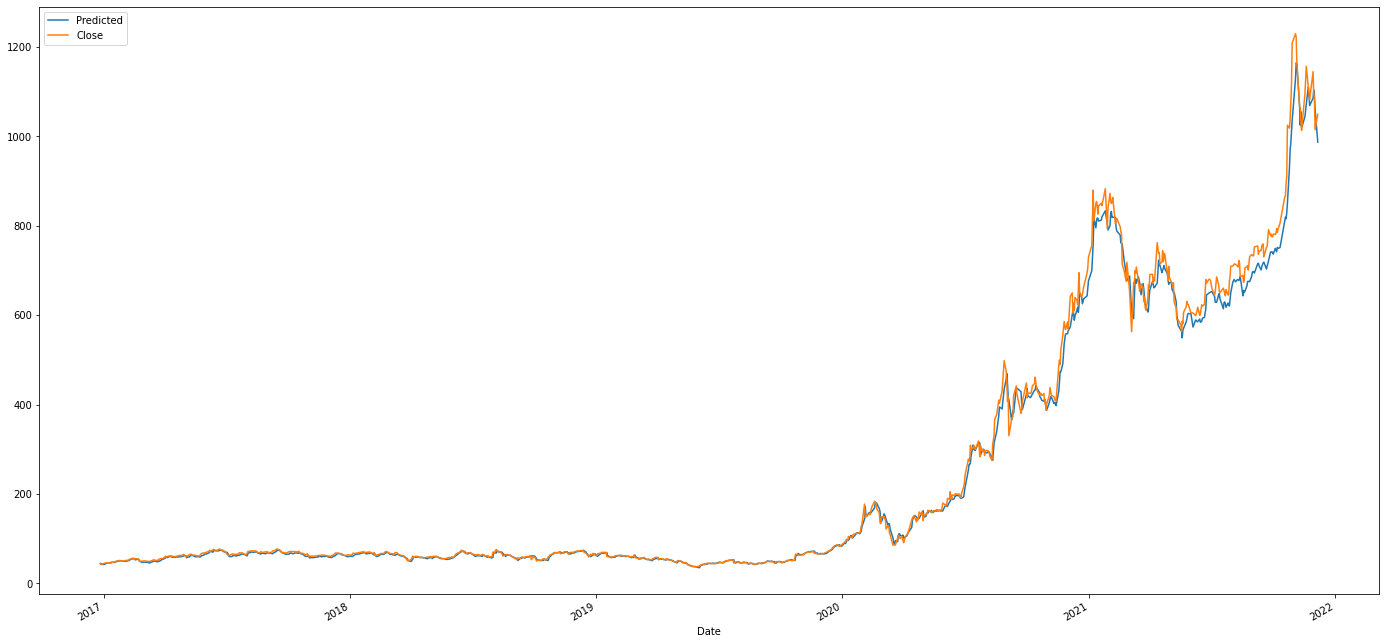

In [64]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error

def svr_linear(ticker, period):
    train_prepared, train_set_labels, test_prepared, test_set_labels = ticker_data_processing(ticker, period)
    plt.close()
    svm_reg = LinearSVR(epsilon= .5, C=.5)
    svm_reg.fit(train_prepared, train_set_labels)
    
    predictions = svm_reg.predict(test_prepared)
    
    scores = cross_val_score(svm_reg, train_prepared, train_set_labels, scoring="neg_mean_squared_error", cv=5 )
    
    rmse = np.sqrt(-scores)
    print("Scores:", rmse)
    print("Mean:", rmse.mean())
    print ("Standared deviation:", rmse.std())
    print("MAPE: ", mean_absolute_percentage_error(test_set_labels, predictions))
    
    
    train_prepared['Predicted Close'] = predictions.tolist()
    train_prepared['Predicted Close'].plot(label="Predicted", figsize=(24,12))
    test_set_labels.plot(label="Close")
    plt.legend()
    
svr_linear('TSLA', '5y')

[*********************100%***********************]  1 of 1 completed


labels             1.000000
Today Adj Close    0.996445
WMA                0.992138
High               0.958254
Open               0.952931
Low                0.950259
RSI                0.332626
ATR                0.113150
ADI                0.012369
Name: labels, dtype: float64

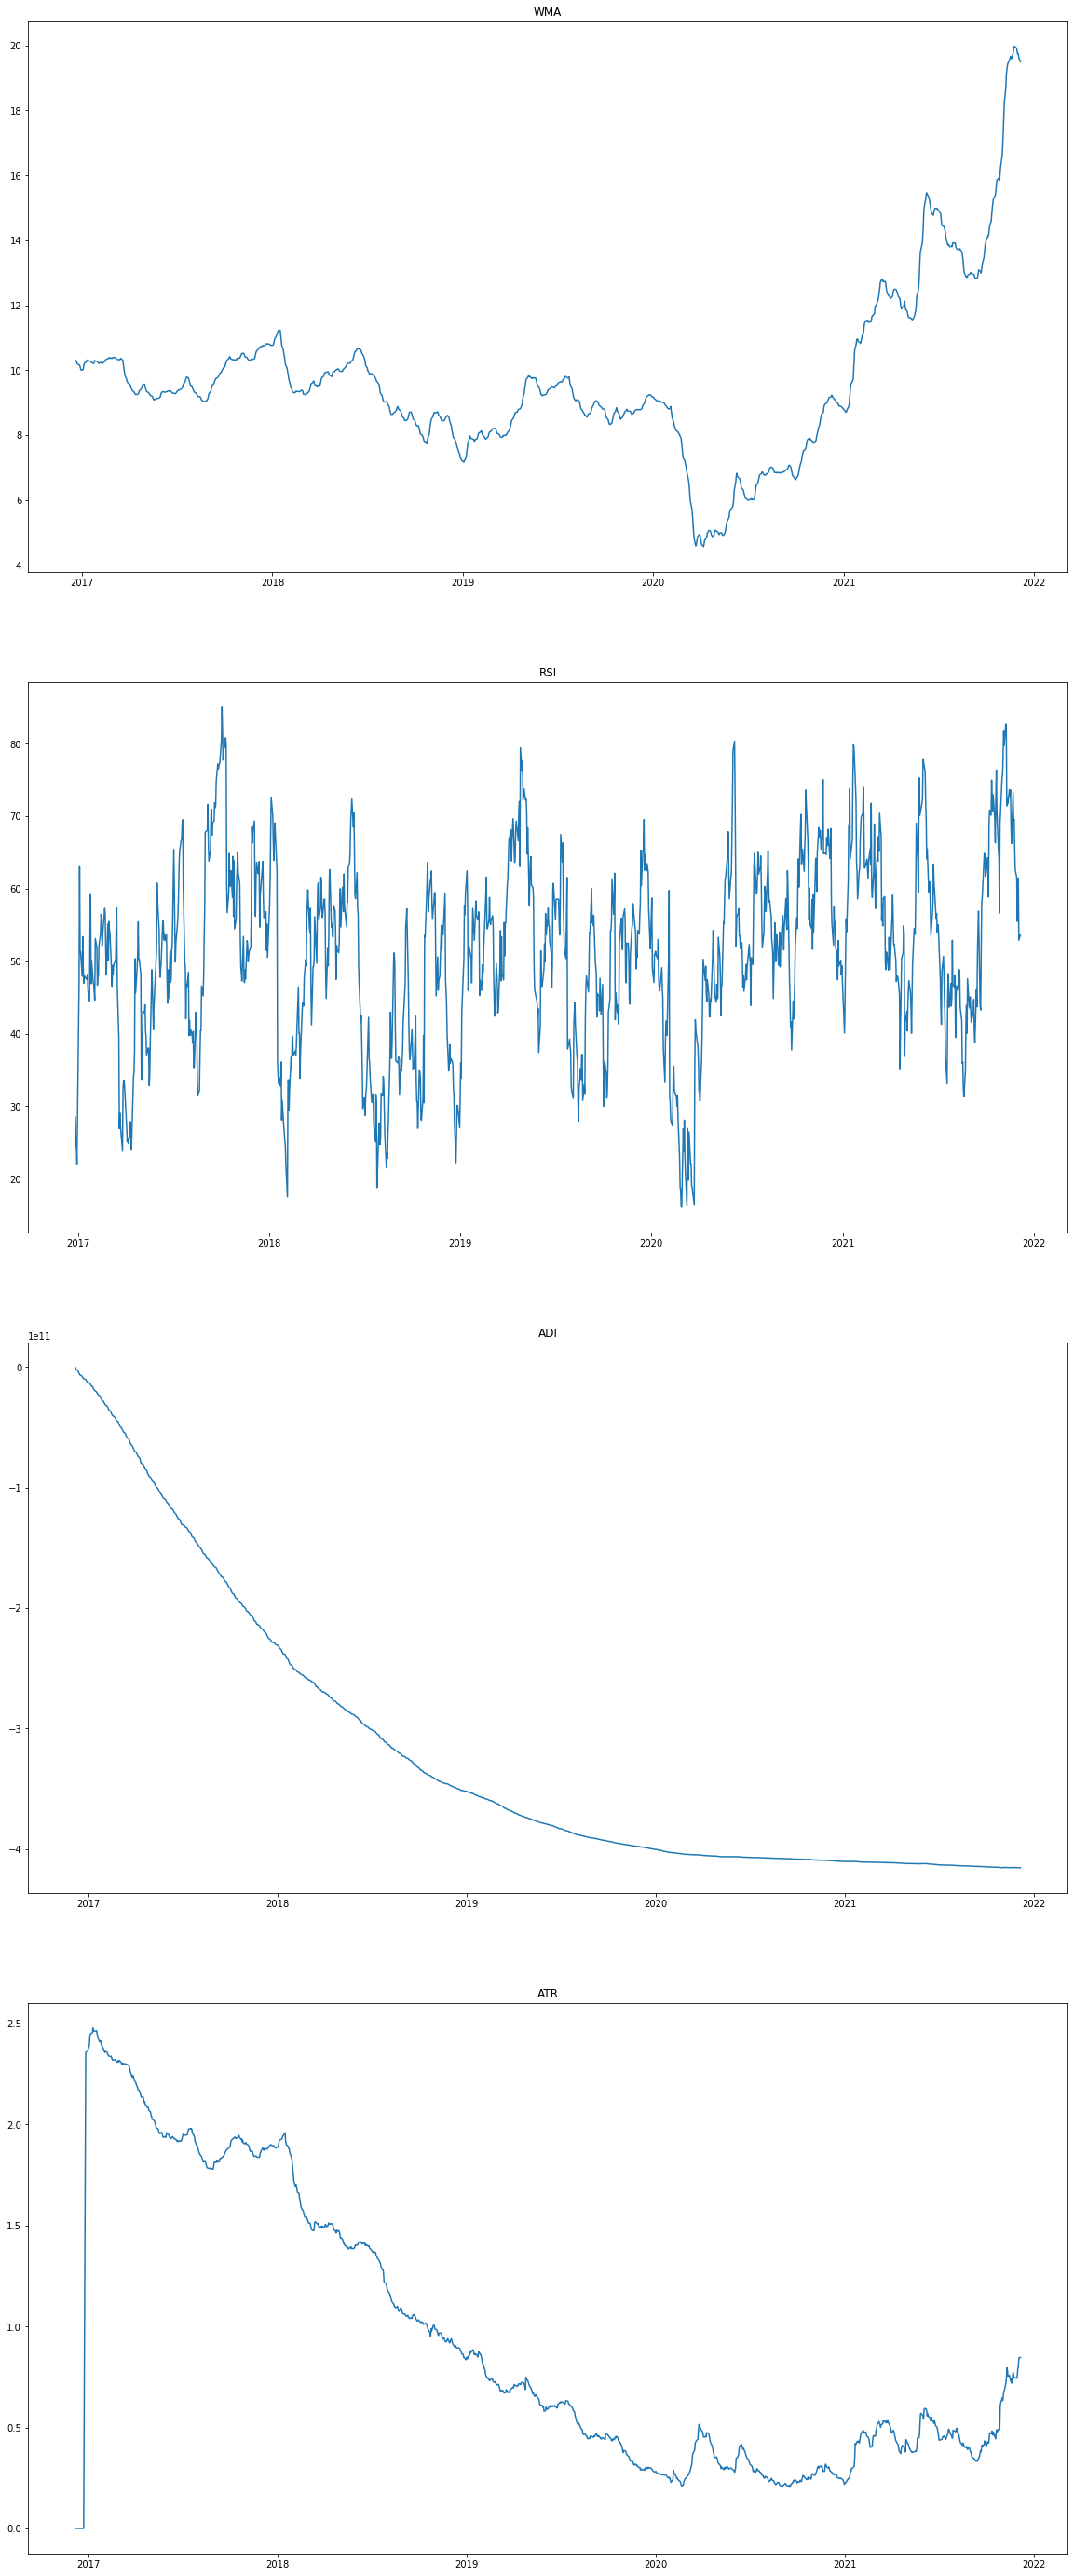

In [65]:
train_prepared, train_set_labels, test_prepared, test_set_labels = ticker_data_processing('F', '5y')
train_prepared['labels']= train_set_labels
corr_matrix = train_prepared.corr()
corr_matrix['labels'].sort_values(ascending=False)

